In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

## Read in Data

In [2]:
data_set = 'test'

In [3]:
# read in data and clean up extra headers
raw_cut_df = pd.read_csv(f'data/{data_set}/cut_iteration.csv', keep_default_na=False)
raw_cut_df = raw_cut_df[raw_cut_df['cut generation iteration'] != 'cut generation iteration']
raw_cut_df = raw_cut_df.astype({'disjunctive terms': 'int64',
                                'cut generation iteration': 'int64',
                                'root gap closed': 'float64'})

raw_restart_df = pd.read_csv(f'data/{data_set}/restart.csv')
raw_restart_df = raw_restart_df[raw_restart_df['restart'] != 'restart']
raw_restart_df = raw_restart_df.astype({'disjunctive terms': 'int64',
                                        'restart': 'int64',
                                        'additional root gap closed': 'float64',
                                        'iterations': 'int64'})

raw_termination_df = pd.read_csv(f'data/{data_set}/termination.csv')
raw_termination_df = raw_termination_df.astype(
    {'default cut generation iterations': 'Int64',
     'default and disjunctive cut generation iterations': 'Int64'}
)

instance_df = pd.read_csv(f'data/{data_set}/instance.csv')

## Summary Statistics

In [4]:
instance_df

,instance
0,gen-ip021
1,flugpl
2,gen-ip002


In [5]:
raw_termination_df

,instance,disjunctive terms,restart termination mode,restart termination notes,final termination mode,default cut generation iterations,default and disjunctive cut generation iterations
0,gen-ip021,4,max number restarts,NaN,stopped on nodes,50,50
1,flugpl,4,max number restarts,NaN,stopped on nodes,50,50
2,gen-ip002,4,restart time limit,NaN,stopped on nodes,50,50
3,gen-ip021,8,restart time limit,NaN,stopped on nodes,50,50
4,flugpl,8,max number restarts,NaN,stopped on nodes,50,50
5,gen-ip002,8,restart time limit,NaN,stopped on nodes,50,50


### Restart Termination Mode

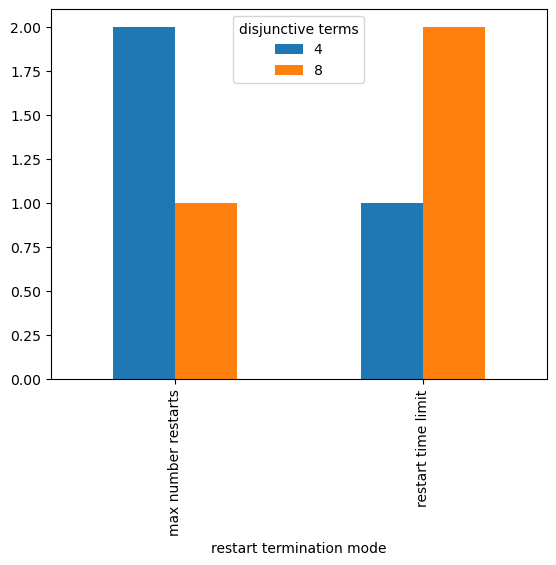

In [6]:
df = raw_termination_df.groupby(['disjunctive terms',
                                 'restart termination mode']).count()['instance'].reset_index()
df.pivot(index='restart termination mode', columns='disjunctive terms')['instance'].plot(kind='bar')
plt.show()

In [7]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 30):
    display(raw_termination_df.pivot(index='instance',
                                     columns='disjunctive terms')['restart termination mode'])

disjunctive terms,4,8
instance,,
flugpl,max number restarts,max number restarts
gen-ip002,restart time limit,restart time limit
gen-ip021,max number restarts,restart time limit


### Final Termination Mode

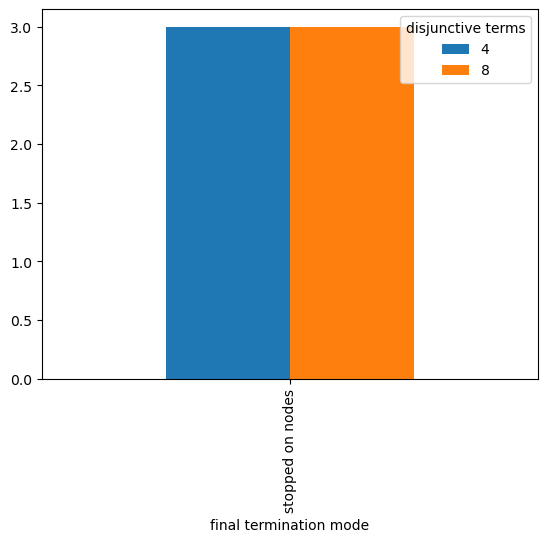

In [8]:
df = raw_termination_df.groupby(['disjunctive terms',
                                 'final termination mode']).count()['instance'].reset_index()
df.pivot(index='final termination mode', columns='disjunctive terms')['instance'].plot(kind='bar')
plt.show()

In [9]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 30):
    display(raw_termination_df.pivot(index='instance',
                                     columns='disjunctive terms')['final termination mode'])

disjunctive terms,4,8
instance,,
flugpl,stopped on nodes,stopped on nodes
gen-ip002,stopped on nodes,stopped on nodes
gen-ip021,stopped on nodes,stopped on nodes


### Number of Restarts (CGLPs Generated)

array([[<AxesSubplot: title={'center': '4'}>],
       [<AxesSubplot: title={'center': '8'}>]], dtype=object)

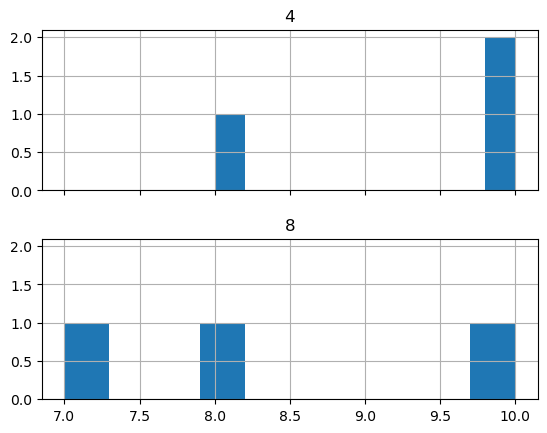

In [10]:
df = raw_restart_df.groupby(['instance', 'disjunctive terms']).max()['restart'].reset_index()
df = df.pivot(index='instance', columns='disjunctive terms')['restart']
df.hist(sharex=True, sharey=True, layout=(len(df.columns), 1))

In [11]:
df

disjunctive terms,4,8
instance,,
flugpl,10,10
gen-ip002,8,7
gen-ip021,10,8


## Root Cut Generation Iterations for Default vs. Both

In [12]:
# remove failed runs
tdf = raw_termination_df[~pd.isna(raw_termination_df['default cut generation iterations'])]
tdf.columns = list(tdf.columns[:-2]) + ['default', 'default and disjunctive']
tdf

,instance,disjunctive terms,restart termination mode,restart termination notes,final termination mode,default,default and disjunctive
0,gen-ip021,4,max number restarts,NaN,stopped on nodes,50,50
1,flugpl,4,max number restarts,NaN,stopped on nodes,50,50
2,gen-ip002,4,restart time limit,NaN,stopped on nodes,50,50
3,gen-ip021,8,restart time limit,NaN,stopped on nodes,50,50
4,flugpl,8,max number restarts,NaN,stopped on nodes,50,50
5,gen-ip002,8,restart time limit,NaN,stopped on nodes,50,50


In [13]:
tdf = pd.melt(tdf, id_vars=['instance', 'disjunctive terms'],
              value_vars=['default', 'default and disjunctive'],
              var_name='cuts', value_name='cut generation iteration')
tdf

,instance,disjunctive terms,cuts,cut generation iteration
0,gen-ip021,4,default,50
1,flugpl,4,default,50
2,gen-ip002,4,default,50
3,gen-ip021,8,default,50
4,flugpl,8,default,50
5,gen-ip002,8,default,50
6,gen-ip021,4,default and disjunctive,50
7,flugpl,4,default and disjunctive,50
8,gen-ip002,4,default and disjunctive,50
9,gen-ip021,8,default and disjunctive,50


In [14]:
m = pd.merge(tdf, raw_cut_df,
             on=['instance', 'cuts', 'disjunctive terms', 'cut generation iteration'],
             how='inner')
m.loc[m['cuts'] == 'default and disjunctive', 'cuts'] = 'both'
m

,instance,disjunctive terms,cuts,cut generation iteration,root gap closed,additional root gap closed
0,gen-ip021,4,default,50,0.045548,1.937603e-06
1,flugpl,4,default,50,0.546468,9.952185e-05
2,gen-ip002,4,default,50,0.048958,3.987735e-05
3,gen-ip021,8,default,50,0.045548,1.937603e-06
4,flugpl,8,default,50,0.546468,9.952185e-05
5,gen-ip002,8,default,50,0.048958,3.987735e-05
6,gen-ip021,4,both,50,0.061222,1.745663e-05
7,flugpl,4,both,50,0.551896,5.156546e-04
8,gen-ip002,4,both,50,0.054761,3.508987e-07
9,gen-ip021,8,both,50,0.098776,2.275778e-05


array([[<AxesSubplot: title={'center': "(4, 'default')"}>,
        <AxesSubplot: title={'center': "(8, 'default')"}>,
        <AxesSubplot: title={'center': "(4, 'both')"}>,
        <AxesSubplot: title={'center': "(8, 'both')"}>],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

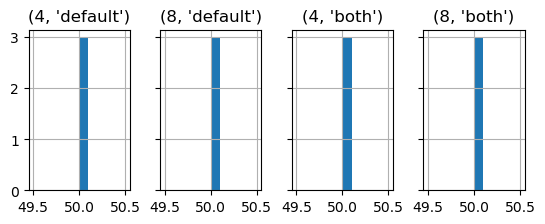

In [15]:
h = m.pivot(index='instance',
            columns=['disjunctive terms', 'cuts'])['cut generation iteration']
h.astype('Int64').hist(sharex=True, sharey=True, layout=(2, 4))

## Remove Bad Runs from Restart and Cut Iteration Data

First, keep only the runs where both the restarted and final runs terminated properly

In [16]:
restart_modes = ['max number restarts', 'restart optimality', 'restart time limit']
final_modes = ['solution', 'stopped on nodes']
good_runs = raw_termination_df.loc[
    raw_termination_df['restart termination mode'].isin(restart_modes) &
    raw_termination_df['final termination mode'].isin(final_modes),
    ['instance', 'disjunctive terms']
]
good_runs

,instance,disjunctive terms
0,gen-ip021,4
1,flugpl,4
2,gen-ip002,4
3,gen-ip021,8
4,flugpl,8
5,gen-ip002,8


In [17]:
# remove unreasonable runs from raw_cut_df
raw_cut_df = pd.merge(raw_cut_df, good_runs, on=['instance', 'disjunctive terms'],
                      how='inner')

In [18]:
# remove unreasonable runs from raw_restart_df
raw_restart_df = pd.merge(raw_restart_df, good_runs, on=['instance', 'disjunctive terms'],
                          how='inner')

Now get rid of runs that terminated properly but then ended up with unreasonable root gap closures

In [19]:
raw_cut_df.loc[raw_cut_df['root gap closed'] > 1.01]

,instance,cuts,disjunctive terms,cut generation iteration,root gap closed,additional root gap closed


In [20]:
# check to make sure no mistakes made in generating cuts via unreasonable root gaps
bad_runs = raw_cut_df.loc[raw_cut_df['root gap closed'] > 1.01, ['instance', 'disjunctive terms']].drop_duplicates()
bad_runs

,instance,disjunctive terms


In [21]:
# remove unreasonable runs from raw_cut_df
merge = pd.merge(raw_cut_df, bad_runs, on=['instance', 'disjunctive terms'],
                 indicator=True, how='outer')
raw_cut_df = merge[merge['_merge'] == 'left_only'].drop('_merge', axis=1)

In [22]:
# remove unreasonable runs from raw_restart_df
merge = pd.merge(raw_restart_df, bad_runs, on=['instance', 'disjunctive terms'],
                 indicator=True, how='outer')
raw_restart_df = merge[merge['_merge'] == 'left_only'].drop('_merge', axis=1)

## Plot Gap Closed at Each Cut Generation Iteration

In [23]:
# group dual bound progress at root by cuts applied and disjunctive terms
cut_df = dict(tuple(raw_cut_df.groupby(['cuts', 'disjunctive terms'])))
cuts = list({k[0] for k in cut_df})
disjunctive_term_list = list({k[1] for k in cut_df})

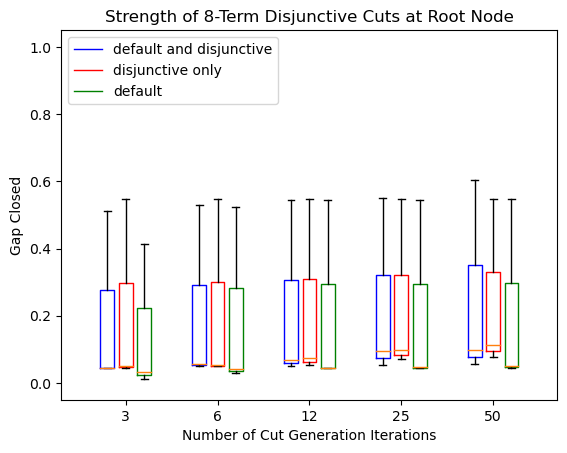

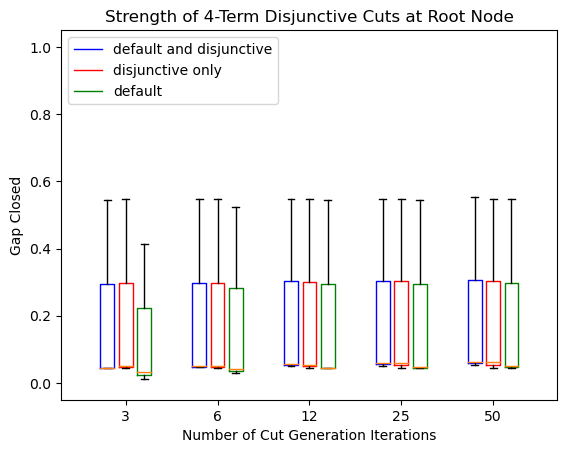

In [24]:
# which cut generation iterations to plot
iterations = [3, 6, 12, 25, 50]

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g']  # must have same length as cuts
bp = {}

# make one plot for each number of disjunctive terms used
for disjunctive_terms in disjunctive_term_list:
    fig, ax = plt.subplots()
    
    # make a collection of box plots for each set of cuts used, plotting selected iterations
    for i, cut in enumerate(cuts):
        
        # get the dual bound progress for this combo of disjunctive term and type of cuts
        df = cut_df[cut, disjunctive_terms]
        
        # filter down to iterations of interest
        df = df[df['cut generation iteration'].isin(iterations)]
        
        # make one box plot for each cut generation iteration of interest
        gb = dict(tuple(df.groupby(['cut generation iteration'])['root gap closed']))
        bp[cut] = ax.boxplot(gb.values(), positions=np.arange(len(iterations))+(i - 1)*shift,
                             boxprops=dict(color=colors[i]), widths=.15)

    # set plot attributes
    ax.legend([b["boxes"][0] for b in bp.values()], bp.keys(), loc='upper left')
    ax.set_xticks(np.arange(len(iterations)))
    ax.set_xticklabels(iterations)
    ax.set(
        title=f'Strength of {disjunctive_terms}-Term Disjunctive Cuts at Root Node',
        xlabel='Number of Cut Generation Iterations',
        ylabel='Gap Closed',
        ylim=(-.05,1.05)
    )

    plt.show()

## Plot Gap Closed By Disjunctive Cuts after Each Restart

In [25]:
raw_restart_df

,instance,disjunctive terms,restart,root gap closed,additional root gap closed,iterations
0,gen-ip021,4,0,0.045550,-6.921155e+01,1
1,gen-ip021,4,1,0.045550,0.000000e+00,1
2,gen-ip021,4,2,0.045550,0.000000e+00,1
3,gen-ip021,4,3,0.045550,0.000000e+00,1
4,gen-ip021,4,4,0.045550,0.000000e+00,1
5,gen-ip021,4,5,0.045550,0.000000e+00,1
6,gen-ip021,4,6,0.045550,0.000000e+00,1
7,gen-ip021,4,7,0.045550,0.000000e+00,1
8,gen-ip021,4,8,0.045550,0.000000e+00,1
9,gen-ip021,4,9,0.045550,0.000000e+00,1


In [26]:
# filter out restarts that occur less than a certain number of times
min_restarts = 10
count = raw_restart_df['restart'].value_counts()
raw_restart_df = raw_restart_df[raw_restart_df['restart'].isin(count.index[count.gt(min_restarts)])]

In [27]:
# group dataframe by number of disjunctive terms
restart_df = dict(tuple(raw_restart_df.groupby('disjunctive terms')[['restart', 'additional root gap closed']]))

AssertionError: colors must have same length as disjunctive term list

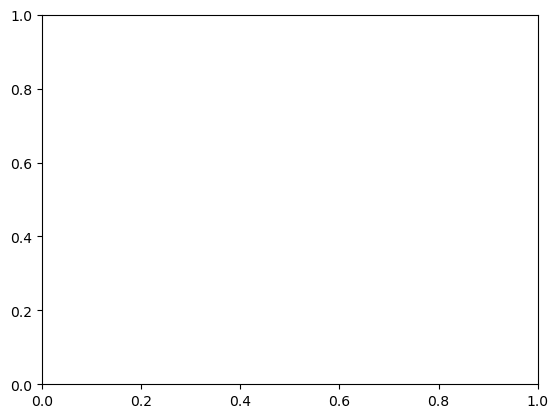

In [28]:
# make one plot for each number of disjunctive terms used
fig, ax = plt.subplots()

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g', 'y']
assert len(colors) == len(restart_df), "colors must have same length as disjunctive term list"
bp = {}
ticks = np.sort(raw_restart_df['restart'].unique())

# for each number of disjunctive terms plot progress of each subsequent restart as box plot
for i, (disjunctive_terms, df) in enumerate(restart_df.items()):
    
    # for each number of disjunctive terms group data frame by restart
    gb = dict(tuple(df.groupby(['restart'])['additional root gap closed']))
    
    # plot each restart as a boxplot
    bp[disjunctive_terms] = ax.boxplot(gb.values(), positions=np.arange(len(gb))+(i - 1.5)*shift,
                                       boxprops=dict(color=colors[i]), widths=.1)

# set plot attributes
ax.legend([b["boxes"][0] for b in bp.values()], [f'{x}-Term Disjunctive Cuts' for x in bp],
          loc='upper left')
ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks)
ax.set(
    title=f'Gap Closed after Each Restart with Only Disjunctive Cuts',
    xlabel='Number of Restarts',
    ylabel='Gap Closed',
    ylim=(-.05,.25),
)
fig.set_size_inches(36, 12)

plt.show()